# CV2 Final Project: Implementation of Pix2Pix
##### Code developed by: Brais Pérez Vázquez and Cristian Pérez Gómez

In this notebook we will implement the necessary code to make the models. In addition we will comment the implemented code explaining point by point what this code does and finally we will see the results obtained.

## Load Needed Functions

We will start by implementing and importing the necessary packages and functions that we will use in all models.

In [79]:
import tensorflow as tf
import time
from matplotlib import pyplot as plt
from IPython import display
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os
import datetime

In [80]:
# Function to load and preprocess images
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

# Function to resize images
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

# Function to perform random cropping
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Function to normalize images
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

# Function for random image jitter
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

# Function to load and preprocess training images
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# Function to load and preprocess test images
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# Function to generate and display images
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

# Function for training step
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

# Function to compute evaluation metrics
def metrics(targets, predicted):
    # Initialize lists to store metric values
    corr = []
    val = []
    mat = []
    sim = []

    # Loop through each image pair
    for i in range(len(predicted)):
        # Load the images
        tar_img = ((targets[i][0]*0.5+0.5).numpy()*255).astype(np.uint8)
        pred_img = ((predicted[i][0]*0.5+0.5).numpy()*255).astype(np.uint8)

        # Convert images to grayscale
        tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_BGR2GRAY)
        pred_gray = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)

        # Method 1: Comparing Histograms
        hist_corr = cv2.compareHist(cv2.calcHist([tar_gray], [0], None, [256], [0, 256]), cv2.calcHist([pred_gray], [0], None, [256], [0, 256]), cv2.HISTCMP_CORREL)
        corr.append(hist_corr)

        # Method 2: Template Matching
        result = cv2.matchTemplate(pred_gray, tar_gray, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        val.append(max_val)

        # Method 3: Feature Matching (SIFT)
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(tar_gray, None)
        kp2, des2 = sift.detectAndCompute(pred_gray, None)
        if des1 is not None and des2 is not None:
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1, des2, k=2)
            good_matches = []
            for match_pair in matches:
                if len(match_pair) >= 2:  # Check if there are at least two matches
                    m, n = match_pair
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)
            matching_ratio = len(good_matches) / min(len(kp1), len(kp2))
            mat.append(matching_ratio)
        else:
            mat.append(0.0)

        # Method 4: SSIM
        similarity_index = ssim(tar_img, pred_img, channel_axis=2, multichannel=True, win_size=7)
        sim.append(similarity_index)

    # Compute mean and standard deviation of metrics
    corr_mean = np.mean(corr)
    corr_std = np.std(corr)
    val_mean = np.mean(val)
    val_std = np.std(val)
    mat_mean = np.mean(mat)
    mat_std = np.std(mat)
    sim_mean = np.mean(sim)
    sim_std = np.std(sim)

    # Print results
    print("Histogram Correlation:", corr_mean, "and standard deviation of:", corr_std)
    print("Template Matching Result:", val_mean, "and standard deviation of:", val_std)
    print("Feature Matching Ratio:", mat_mean, "and standard deviation of:", mat_std)
    print("Similarity:", sim_mean, "and standard deviation of:", sim_std)

    # Return computed metric values
    return [corr_mean, corr_std, val_mean, val_std, mat_mean, mat_std, sim_mean, sim_std]

# Function for model training
def fit(train_ds, val_ds, steps):
  # Initialize lists to store metrics during training
  mets = []
  mets_val = []

  # Get example input and target from validation dataset
  example_input, example_target = next(iter(val_ds.take(1)))
  start = time.time()

  # Loop through training steps
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
        display.clear_output(wait=True)

        if step != 0:
            print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            predicted = []
            targets = []

            print('---------------------------------------------------------------------')
            print('----------------------------Training---------------------------------')
            print('---------------------------------------------------------------------')

            # Generate predictions for training dataset
            for inp, tar in train_ds.take(400):
                out = generator(inp)
                targets.append(tar)
                predicted.append(out)
            # Compute metrics for training dataset
            output = metrics(targets, predicted)
            mets.append(output)

            print('---------------------------------------------------------------------')
            print('--------------------------Validation---------------------------------')
            print('---------------------------------------------------------------------')

            # Generate predictions for validation dataset
            predicted = []
            targets = []
            for inp, tar in val_ds.take(50):
                out = generator(inp)
                targets.append(tar)
                predicted.append(out)
            # Compute metrics for validation dataset
            output = metrics(targets, predicted)
            mets_val.append(output)

        start = time.time()

        # Display example images and step number
        generate_images(generator, example_input, example_target)
        print(f"Step: {step//1000}k")

    # Perform a training step
    train_step(input_image, target, step)

    # Print progress
    if (step+1) % 10 == 0:
        print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 20000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

  return mets, mets_val

# Function to plot evaluation metrics
def show_plots(mets, mets_val):
  # Initialize lists to store metric values
  corr_mean = []
  corr_std = []
  temp_mean = []
  temp_std = []
  feat_mean = []
  feat_std = []
  corr_mean_val = []
  corr_std_val = []
  temp_mean_val = []
  temp_std_val = []
  feat_mean_val = []
  feat_std_val = []
  sim_mean = []
  sim_std = []
  sim_mean_val = []
  sim_std_val = []

  # Extract metric values from lists
  for i in range(len(mets)):
      corr_mean.append(mets[i][0])
      corr_std.append(mets[i][1])
      temp_mean.append(mets[i][2])
      temp_std.append(mets[i][3])
      feat_mean.append(mets[i][4])
      feat_std.append(mets[i][5])
      sim_mean.append(mets[i][6])
      sim_std.append(mets[i][7])
  for i in range(len(mets_val)):
      corr_mean_val.append(mets_val[i][0])
      corr_std_val.append(mets_val[i][1])
      temp_mean_val.append(mets_val[i][2])
      temp_std_val.append(mets_val[i][3])
      feat_mean_val.append(mets_val[i][4])
      feat_std_val.append(mets_val[i][5])
      sim_mean_val.append(mets[i][6])
      sim_std_val.append(mets[i][7])

  # Create subplots
  fig, axs = plt.subplots(4, 1, figsize=(10, 10))

  # Plot for Template Matching
  axs[0].plot(temp_mean, marker='o', linestyle='-', color='b', label='Mean')
  for i in range(len(temp_mean)):
      axs[0].plot([i, i], [temp_mean[i] - temp_std[i], temp_mean[i] + temp_std[i]], color='r')
  axs[0].plot(temp_mean_val, marker='o', linestyle='-', color='g', label='Mean')
  for i in range(len(temp_mean_val)):
      axs[0].plot([i, i], [temp_mean_val[i] - temp_std_val[i], temp_mean_val[i] + temp_std_val[i]], color='r')
  axs[0].set_title('Template Matching')
  axs[0].set_xlabel('Data Points')
  axs[0].set_ylabel('Values') 
  axs[0].set_ylim(0, 1)
  axs[0].grid(True)

  # Plot for Feature Extraction
  axs[1].plot(feat_mean, marker='o', linestyle='-', color='b', label='Mean')
  for i in range(len(feat_mean)):
      axs[1].plot([i, i], [feat_mean[i] - feat_std[i], feat_mean[i] + feat_std[i]], color='r')
  axs[1].plot(feat_mean_val, marker='o', linestyle='-', color='g', label='Mean')
  for i in range(len(feat_mean_val)):
      axs[1].plot([i, i], [feat_mean_val[i] - feat_std_val[i], feat_mean_val[i] + feat_std_val[i]], color='r')
  axs[1].set_title('Feature Extraction')
  axs[1].set_xlabel('Data Points')
  axs[1].set_ylabel('Values')
  axs[1].grid(True)

  # Plot for Correlation of Histograms
  axs[2].plot(corr_mean, marker='o', linestyle='-', color='b', label='Mean')
  for i in range(len(corr_mean)):
      axs[2].plot([i, i], [corr_mean[i] - corr_std[i], corr_mean[i] + corr_std[i]], color='r')
  axs[2].plot(corr_mean_val, marker='o', linestyle='-', color='g', label='Mean')
  for i in range(len(corr_mean_val)):
      axs[2].plot([i, i], [corr_mean_val[i] - corr_std_val[i], corr_mean_val[i] + corr_std_val[i]], color='r')
  axs[2].set_title('Correlation of Histograms')
  axs[2].set_xlabel('Data Points')
  axs[2].set_ylabel('Values')
  axs[2].grid(True)

  # Plot for Similarity
  axs[3].plot(sim_mean, marker='o', linestyle='-', color='b', label='Mean')
  for i in range(len(sim_mean)):
      axs[3].plot([i, i], [sim_mean[i] - sim_std[i], sim_mean[i] + sim_std[i]], color='r')
  axs[3].plot(sim_mean_val, marker='o', linestyle='-', color='g', label='Mean')
  for i in range(len(sim_mean_val)):
      axs[3].plot([i, i], [sim_mean_val[i] - sim_std_val[i], sim_mean_val[i] + sim_std_val[i]], color='r')
  axs[3].set_title('Similarity')
  axs[3].set_xlabel('Data Points')
  axs[3].set_ylabel('Values')
  axs[3].grid(True)

  # Adjust layout
  plt.tight_layout()

  # Show plots
  plt.show()

## Introduction

In this notebook we will develop the necessary code to implement the generative models that generate an image from the image labels. With respect to the models, we will first develop the Pix2Pix model, and then we will make some changes within the model architecture to try to improve the models. To train and validate the models we will use the reduced Cityscapes dataset, these images will have a size of 256x256 and will consist of 500 images in total. Finally, and at a general level for all the models, we will describe the metrics that we will use to evaluate the reliability of the models. It should be noted that all models will be trained on the same steps, so that comparisons are as fair as possible. We will also try to train them with the same computer and under the same conditions in order to be able to compare the computational cost of the models. These metrics are as follows: 

1. ***Histogram Correlation***: Correlation measures the similarity between histograms. A value close to 1 indicates high similarity, while a value close to -1 indicates high dissimilarity

2. ***Template Matching***: Once we perform the template matching between the target and the output of the model, this score indicates the similarity or match between the template and the image patch at the location with the highest correlation, the value varies between -1 and 1. 

3. ***Feature Extraction***: Once we made the feature extraction, we score if the features extracted are the same and we calculate the matching ratio of the simmilar features. This matching ratio ranges from 0 to 1, 0 indicating that none of the keypoints are matching and 1 that all of them are matching. 

4. ***Similarity, SSIM***: compares three components locally across the entire image; luminance, contrast and structure, and produces a similarity index for each pixel. These local similarity indices are then averaged to produce the overall SSIM value for the entire image. SSIM values range from -1 to 1, where 1 indicates perfect similarity between the two images, and values closer to 1 indicate higher similarity.

Although we will use all four metrics to make the model evaluation more robust, we will mainly draw our conclusions with the SSIM. We will also show some test images so that, in addition to the metrics, a personal evaluation of the model can also be made.  

![Example Image](Images\example.png)



As we said we will start with the Pix2Pix model, for this we will use the basic model that is implemented in the TensorFlow documentation. 

Note: With the way the code is developed, any of the three models can be executed independently without having to load the previous models. 

## 1. Pix2Pix Model

### Load Functions

In [81]:
# Function for down-sampling layers in the generator model
def downsample(filters, size, apply_batchnorm=True):
    # Initialize weights with a normal distribution
    initializer = tf.random_normal_initializer(0., 0.02)

    # Create a sequential model
    result = tf.keras.Sequential()
    
    # Add convolutional layer
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    
    # Add batch normalization layer if specified
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    # Add LeakyReLU activation function
    result.add(tf.keras.layers.LeakyReLU())

    return result


# Function for up-sampling layers in the generator model
def upsample(filters, size, apply_dropout=False):
    # Initialize weights with a normal distribution
    initializer = tf.random_normal_initializer(0., 0.02)

    # Create a sequential model
    result = tf.keras.Sequential()
    
    # Add transpose convolutional layer
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    
    # Add batch normalization layer
    result.add(tf.keras.layers.BatchNormalization())
    
    # Add dropout layer if specified
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    # Add ReLU activation function
    result.add(tf.keras.layers.ReLU())

    return result


# Generator model definition
def Generator():
    # Input layer
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Define down-sampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # Define up-sampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    # Define final convolutional layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')  # (batch_size, 256, 256, 3)

    # Forward pass
    x = inputs
    skips = []

    # Perform down-sampling through the model
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Perform up-sampling and establish skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


# Loss function for generator model
def generator_loss(disc_generated_output, gen_output, target):
    # Compute adversarial loss using binary cross-entropy
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Compute mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Compute total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


# Discriminator model definition
def Discriminator():
    # Initialize weights with a normal distribution
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input layers for input and target images
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Concatenate input and target images
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    # Define down-sampling layers
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    # Zero padding
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    # Batch normalization layer
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    # LeakyReLU activation function
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Zero padding
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    # Last convolutional layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# Loss function for discriminator model
def discriminator_loss(disc_real_output, disc_generated_output):
    # Compute loss for real and generated images using binary cross-entropy
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Compute total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### Train the model

First we will import the scripts where we have all the necessary functions to implement the model. We will also define the variables needed for the model and the optimisers and loss functions of the models. In this case we will not go into more detail in the code behind the models as it is a slight modification of the code provided by the [Tensor-Flow](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=es-419) documentation (we will also add some comments in the corresponding scripts). The major modifications implemented in the TensorFlow code are at the time of evaluating the results, where we calculate the metrics previously described and store all these results in a vector, both for the evaluation set and the test set. 

In [82]:
dataset_name = 'cityscapes/'

BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

We load two images, an example of the input that the model will receive and an example of the target that the model should end up giving in an optimal case. 

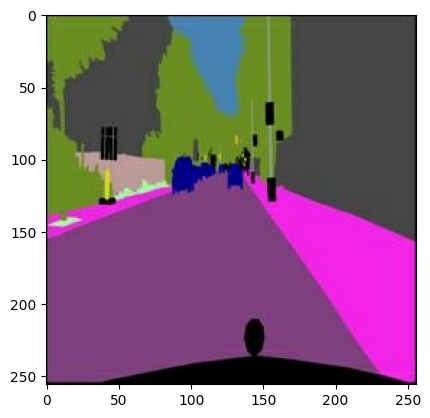

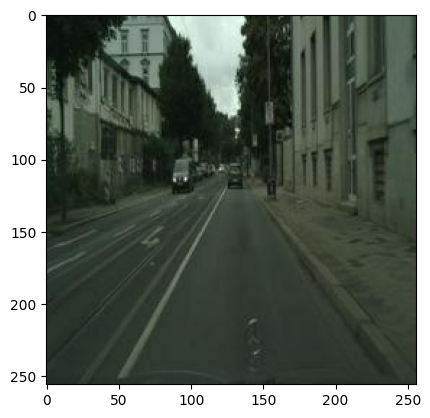

In [83]:
inp, re = load(str(dataset_name + 'image_100.jpg'))

plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Here we can see how one of the defined functions generates small changes in the image (preprocessing data).

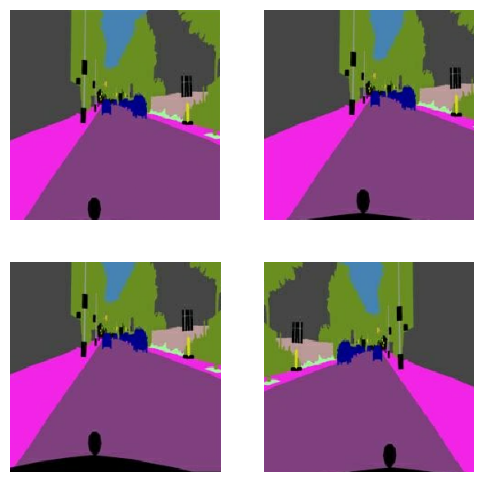

In [84]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Next we will load all the images in the dataset, 500 in total, and divide them into training, test and validation. For the training set we will use 400 images while for both the test set and the validation set we will use 50 images. 

In [85]:
train = tf.data.Dataset.list_files(str(dataset_name + 'image_*.jpg'))
train = train.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(BUFFER_SIZE)
train = train.batch(BATCH_SIZE)

train_dataset = train.take(400)
test = train.skip(400)
test_dataset = test.take(50)
val_dataset = test.skip(50)

We call the functions that will generate the generator and the discriminator that we will use for our GAN. 

In [86]:
generator = Generator()

gen_output = generator(inp[tf.newaxis, ...], training=False)

discriminator = Discriminator()

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)

We define a directory where we will store the different checkpoints of the model (in our case every 20000 steps).

In [87]:
checkpoint_dir = './training_checkpoints_UNet'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

We show an image, where we show the input, the target and the output. At this point, as is evident, the output is an image with only noise because the model is not trained. 

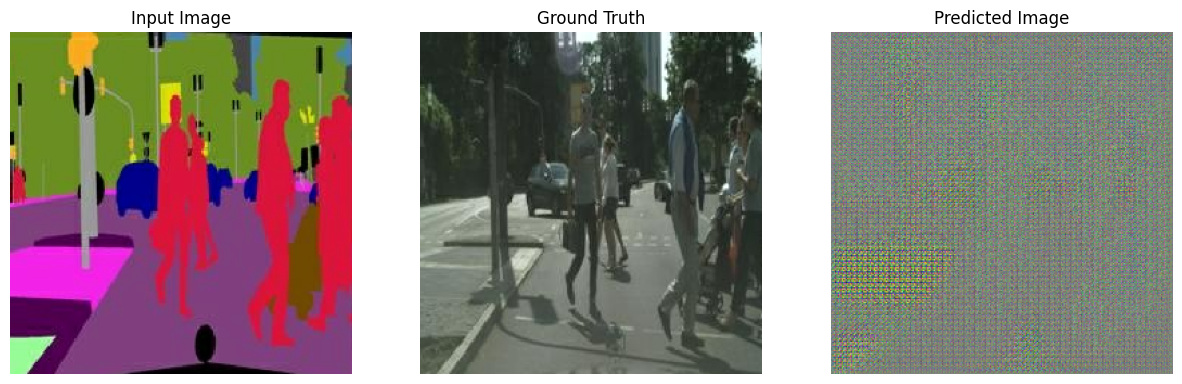

In [88]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

Next we will train the model with 60000 steps. Every 1000 steps the information displayed will be updated, showing the time it took to execute the previous thousand steps and the training and validation metrics at that moment. In addition we will show a prediction of an image to see how the model is evolving. 

Time taken for 1000 steps: 800.09 sec

---------------------------------------------------------------------
----------------------------Training---------------------------------
---------------------------------------------------------------------
Histogram Correlation: -0.10190176633802085 and standard deviation of: 0.0804197724094268
Template Matching Result: 0.07445482122862813 and standard deviation of: 0.12806342119336406
Feature Matching Ratio: 0.05257120135311839 and standard deviation of: 0.25164603222408694
Similarity: 0.16952646220231515 and standard deviation of: 0.04772806686733524
---------------------------------------------------------------------
--------------------------Validation---------------------------------
---------------------------------------------------------------------
Histogram Correlation: -0.1268737342664273 and standard deviation of: 0.07423594392546021
Template Matching Result: 0.06358673910610378 and standard deviation of: 0.14234245503915202
Featu

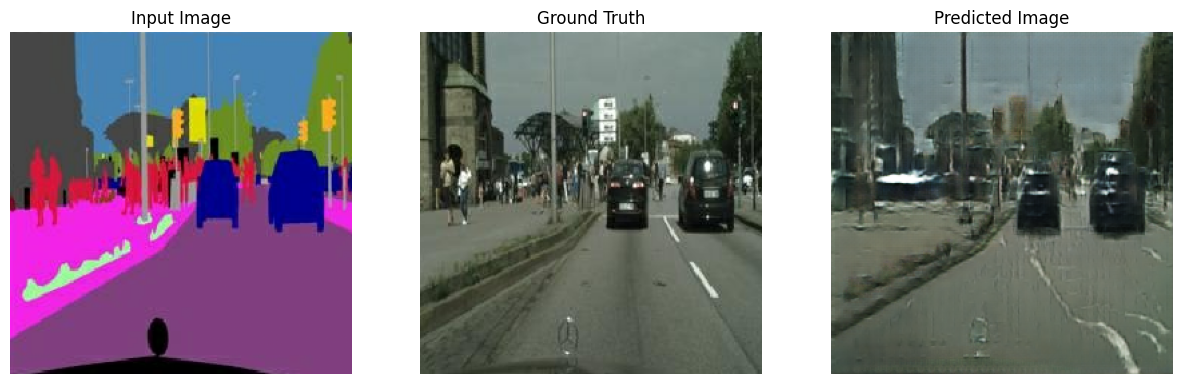

Step: 59k
....................................................................................................

In [89]:
metric, metrics_validation = fit(train_dataset, val_dataset, steps=60000)

np.save('Metrics_UNet', metric)
np.save('Metrics_UNet_Validation', metrics_validation)

Once we have trained the model we will represent the evolution of the graphs throughout the training. To do so, we will represent each one of them every thousand steps, representing with a dot the mean of the metric in all the images evaluated and with a red vertical line the standard deviation. In addition, we will represent an image generated by the model next to the target image in order to be able to compare them. 

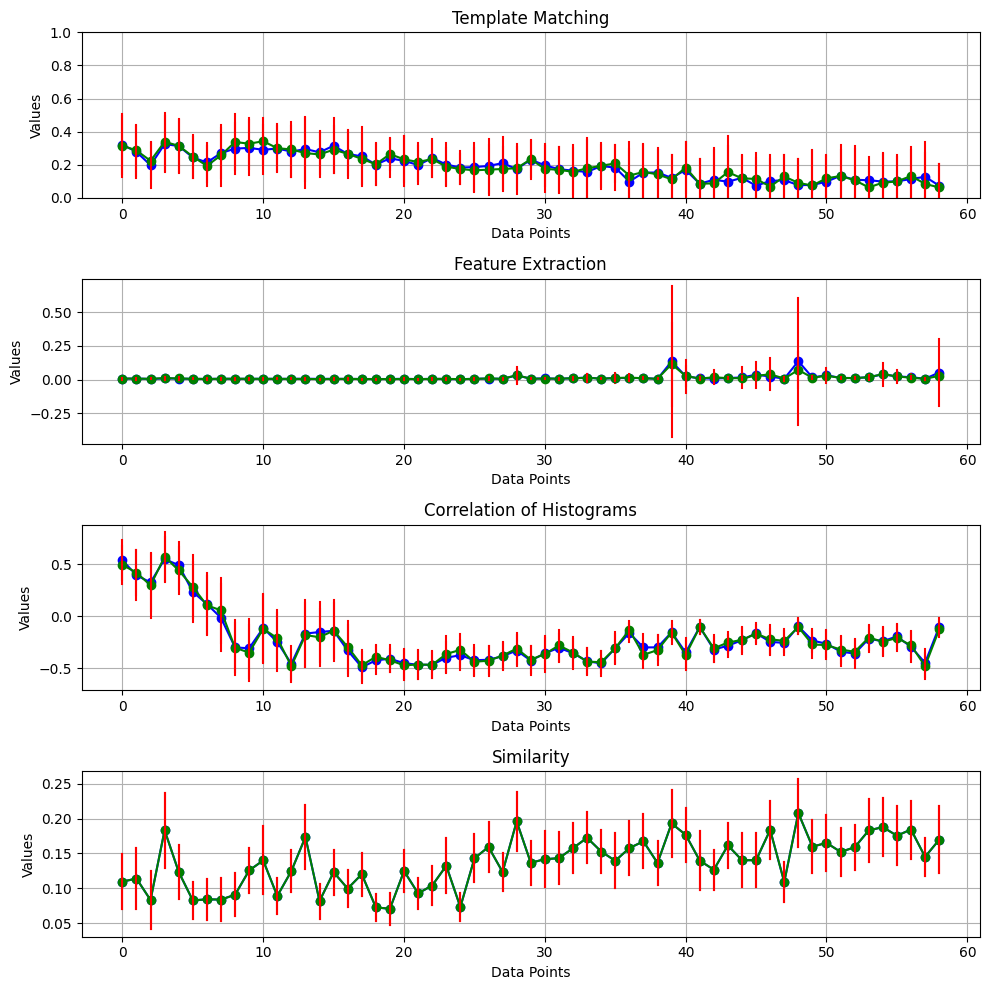

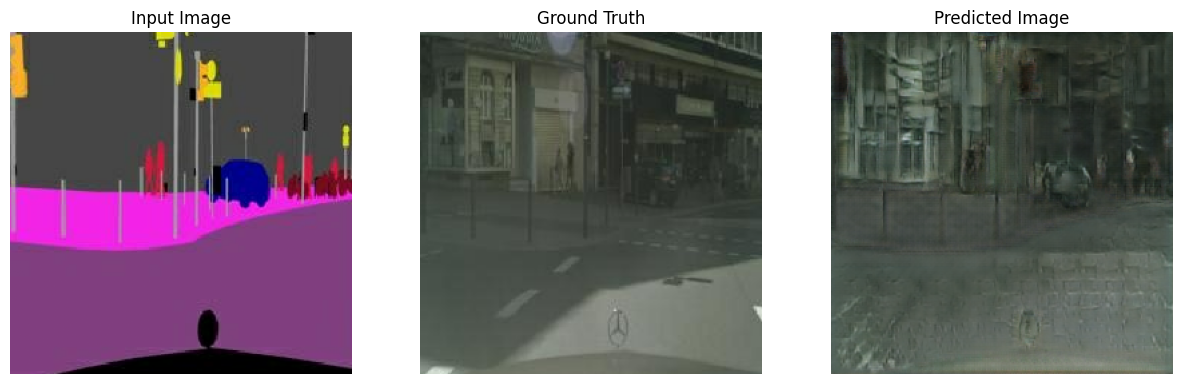

In [90]:
show_plots(metric, metrics_validation)

for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

Finally, let's look at the metrics obtained by the model on the test set. 

In [91]:
predicted = []
targets = []

for inp, tar in test_dataset.take(50):
    out = generator(inp)
    targets.append(tar)
    predicted.append(out)

output = metrics(targets, predicted)

Histogram Correlation: -0.4981112628955197 and standard deviation of: 0.08131357557096217
Template Matching Result: 0.1370374758914113 and standard deviation of: 0.19453135375584107
Feature Matching Ratio: 0.006908377043152596 and standard deviation of: 0.007161948456761056
Similarity: 0.12733220143226082 and standard deviation of: 0.025169367414729353


## 2. ResNet instead UNet

### Load Functions

In [92]:
# Function to define a residual block
def residual_block(x, filters, kernel_size=3, strides=1, apply_dropout=False):
    # Store the shortcut connection
    x_shortcut = x

    # First convolutional layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Adjust the shortcut connection if the strides are not equal to 1
    if strides != 1:
        x_shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(x_shortcut)
        x_shortcut = tf.keras.layers.BatchNormalization()(x_shortcut)

    # Add the shortcut connection to the output of the second convolutional layer
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.ReLU()(x)

    # Apply dropout if specified
    if apply_dropout:
        x = tf.keras.layers.Dropout(0.5)(x)

    return x


# Generator model definition
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Downsampling blocks
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 512, strides=2)

    # Upsampling blocks
    x = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, 256)
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = residual_block(x, 128)
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Final convolutional layer
    outputs = tf.keras.layers.Conv2DTranspose(3, 7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Discriminator model definition
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input layers for input and target images
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Concatenate input and target images
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    # Define down-sampling layers
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    # Zero padding
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    # Batch normalization layer
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    # LeakyReLU activation function
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Zero padding
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    # Last convolutional layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# Loss function for discriminator model
def discriminator_loss(disc_real_output, disc_generated_output):
    # Compute loss for real and generated images using binary cross-entropy
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Compute total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


# Function to downsample the input using convolutional layers
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


# Function to upsample the input using transpose convolutional layers
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# Loss function for generator model
def generator_loss(disc_generated_output, gen_output, target):
    # Compute adversarial loss using binary cross-entropy
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Compute mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Compute total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Function for training step
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


### Train Models

In this second model we will use a similar code to the one used in the first model, we will take advantage of the code developed in TensorFlow and we will modify the generator to implement a ResNet network instead of a UNet. We chose ResNet for its deep architecture with skip connections, addressing vanishing gradient issues. ResNet's residual blocks facilitate smoother training of deep networks, enabling efficient learning of complex features. Its modular and scalable design allows for customization according to task complexity, making it a suitable choice for tasks demanding deeper architectures and robust performance. Additionally, ResNet's proven effectiveness in various computer vision tasks aligns with our project's requirements for high-performance models.

The structure we will follow to test this model is completely analogous to the one used in the previous model, so we will not make any further comments other than to comment on the results obtained (Some of the code boxes are repeated and are of little interest, but they are there so that you can run each of the three models individually without needing the code from the previous ones. ).

In [93]:
dataset_name = 'cityscapes/'

BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [94]:
train = tf.data.Dataset.list_files(str(dataset_name + 'image_*.jpg'))
train = train.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(BUFFER_SIZE)
train = train.batch(BATCH_SIZE)

train_dataset = train.take(400)
test = train.skip(400)
test_dataset = test.take(50)
val_dataset = test.skip(50)

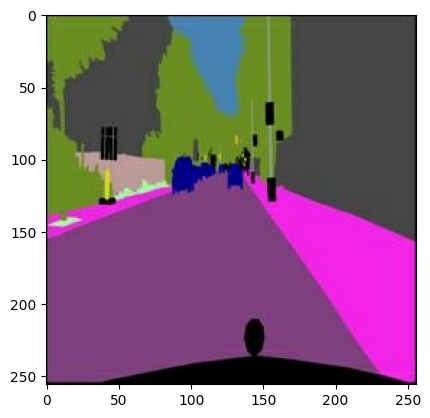

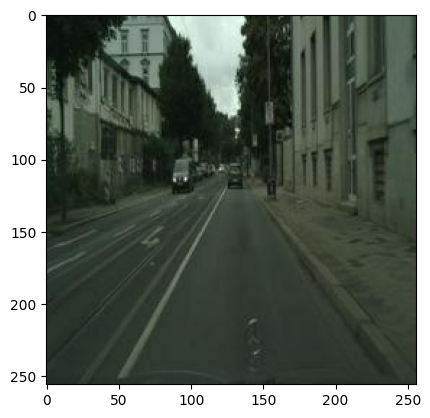

In [95]:
inp, re = load(str(dataset_name + 'image_100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [96]:
generator = Generator()

gen_output = generator(inp[tf.newaxis, ...], training=False)

discriminator = Discriminator()

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)

In [97]:
checkpoint_dir = './training_checkpoints_ResNet'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Time taken for 1000 steps: 893.21 sec

---------------------------------------------------------------------
----------------------------Training---------------------------------
---------------------------------------------------------------------
Histogram Correlation: 0.5504657570767204 and standard deviation of: 0.22777145915114638
Template Matching Result: 0.5065392311359755 and standard deviation of: 0.20678094442604575
Feature Matching Ratio: 0.022035924812243143 and standard deviation of: 0.015491866752146794
Similarity: 0.4118141534307755 and standard deviation of: 0.07587876929584338
---------------------------------------------------------------------
--------------------------Validation---------------------------------
---------------------------------------------------------------------
Histogram Correlation: 0.564807100346548 and standard deviation of: 0.20654200030007527
Template Matching Result: 0.5052082816883922 and standard deviation of: 0.19570752710139738
Feature M

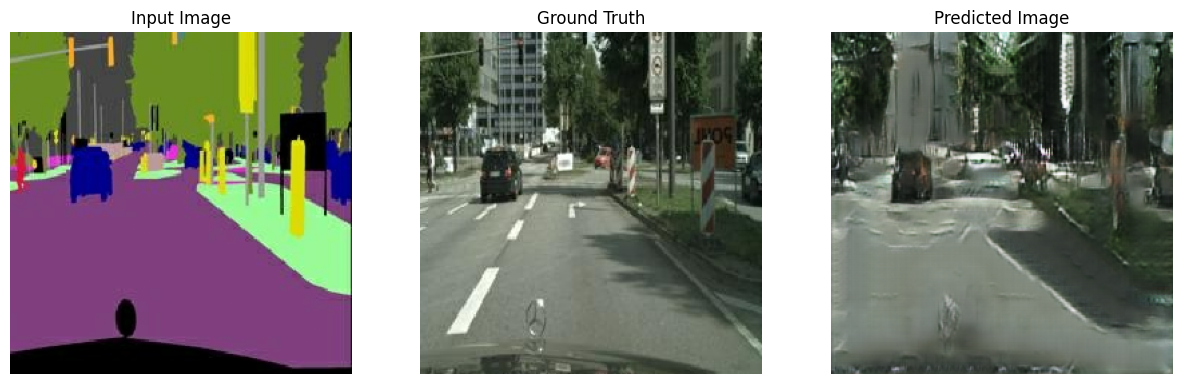

Step: 59k
....................................................................................................

In [98]:
metric, metrics_validation = fit(train_dataset, val_dataset, steps=60000)

np.save('Metrics_ResNet', metric)
np.save('Metrics_ResNet_Validation', metrics_validation)

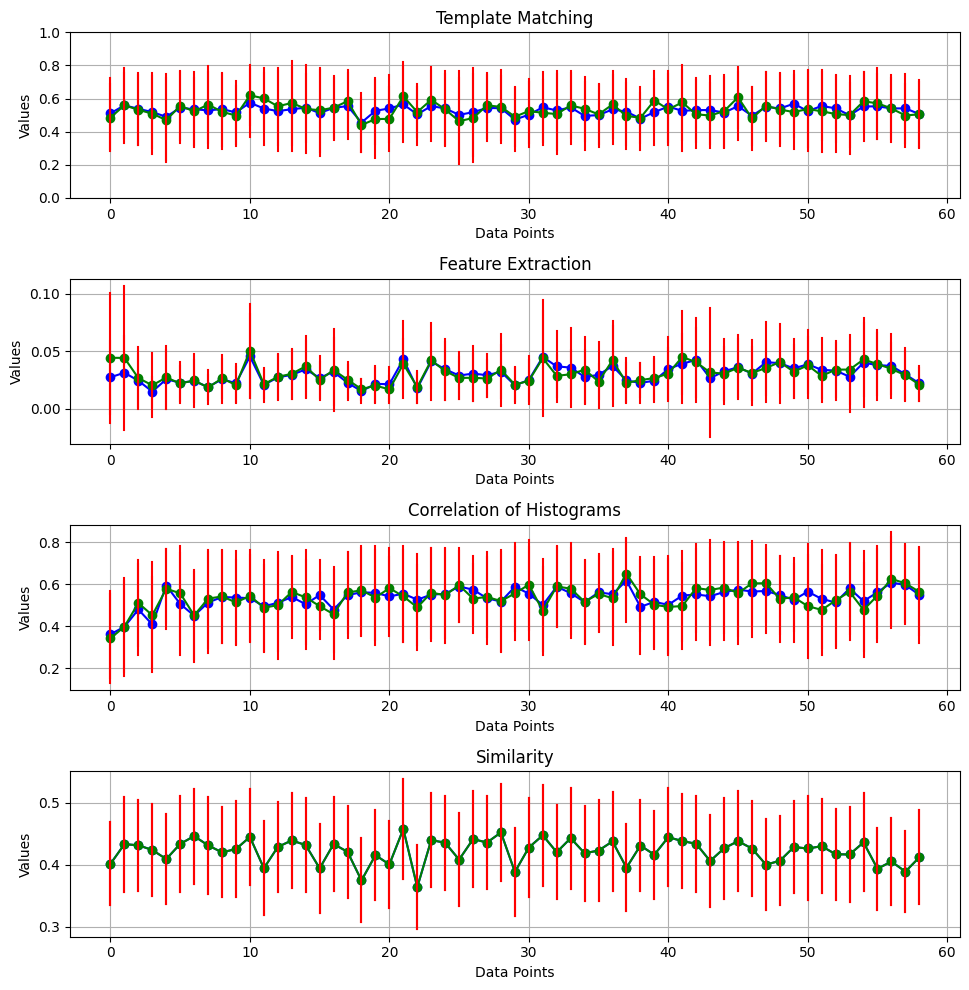

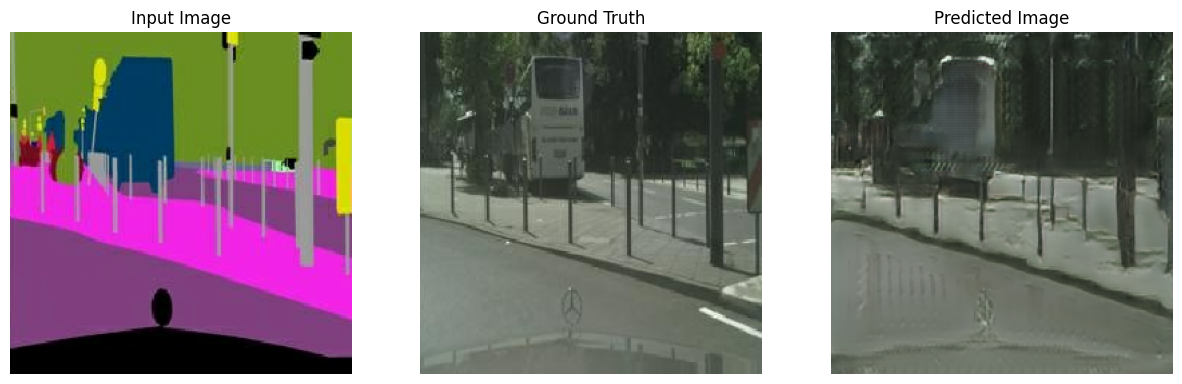

In [99]:
show_plots(metric, metrics_validation)

for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

In [100]:
predicted = []
targets = []

for inp, tar in test_dataset.take(50):
    out = generator(inp)
    targets.append(tar)
    predicted.append(out)

output = metrics(targets, predicted)

Histogram Correlation: 0.5942675474943314 and standard deviation of: 0.20451382506275523
Template Matching Result: 0.5911442473530769 and standard deviation of: 0.16995071968918732
Feature Matching Ratio: 0.033188496153143614 and standard deviation of: 0.02802514442546294
Similarity: 0.4366901691497753 and standard deviation of: 0.08038537078927128


## 3. Ensemble

### Load Functions

In [101]:
# Function to define a residual block
def residual_block(x, filters, kernel_size=3, strides=1, apply_dropout=False):
    # Store the shortcut connection
    x_shortcut = x

    # First convolutional layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Adjust the shortcut connection if the strides are not equal to 1
    if strides != 1:
        x_shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(x_shortcut)
        x_shortcut = tf.keras.layers.BatchNormalization()(x_shortcut)

    # Add the shortcut connection to the output of the second convolutional layer
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.ReLU()(x)

    # Apply dropout if specified
    if apply_dropout:
        x = tf.keras.layers.Dropout(0.5)(x)

    return x


# Generator model definition
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Downsampling blocks (similar to DCGAN)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Residual blocks (similar to ResNet)
    for _ in range(4):
        x = residual_block(x, 512)

    # Upsampling blocks (similar to DCGAN)
    x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Final convolutional layer (similar to StyleGAN)
    outputs = tf.keras.layers.Conv2DTranspose(3, 7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Discriminator model definition
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input layers for input and target images
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # Concatenate input and target images
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    # Define down-sampling layers
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    # Zero padding
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    # Batch normalization layer
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    # LeakyReLU activation function
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Zero padding
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    # Last convolutional layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# Loss function for discriminator model
def discriminator_loss(disc_real_output, disc_generated_output):
    # Compute loss for real and generated images using binary cross-entropy
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Compute total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


# Function to downsample the input using convolutional layers
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


# Function to upsample the input using transpose convolutional layers
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# Loss function for generator model
def generator_loss(disc_generated_output, gen_output, target):
    # Compute adversarial loss using binary cross-entropy
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Compute mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Compute total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

# Function for training step
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

### Train Model

For this third model we follow the same philosophy as the previous one where we take the general model defined in TensorFlow and slightly modify the generator. In this case, instead of opting for a known architecture, we chose to mix different types of generators to observe the results. 

The generator applies an initial convolutional layer to extract features. It then utilizes downsampling blocks, similar to DCGAN, to gradually reduce spatial dimensions while increasing the number of channels. Subsequently, residual blocks, inspired by ResNet, are employed to capture and retain essential features across layers. Finally, the generator upsamples the feature maps using transpose convolutional layers to reconstruct the output image, and a final convolutional layer with tanh activation ensures pixel value normalization.

As in the previous model, the structure we will follow will be similar, so we will only comment on the results we obtained (Some of the code boxes are repeated and are of little interest, but they are there so that you can run each of the three models individually without needing the code from the previous ones. ).

In [102]:
dataset_name = 'cityscapes/'

BUFFER_SIZE = 500
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNeLS = 3
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


train = tf.data.Dataset.list_files(str(dataset_name + 'image_*.jpg'))
train = train.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(BUFFER_SIZE)
train = train.batch(BATCH_SIZE)

train_dataset = train.take(400)
test = train.skip(400)
test_dataset = test.take(50)
val_dataset = test.skip(50)

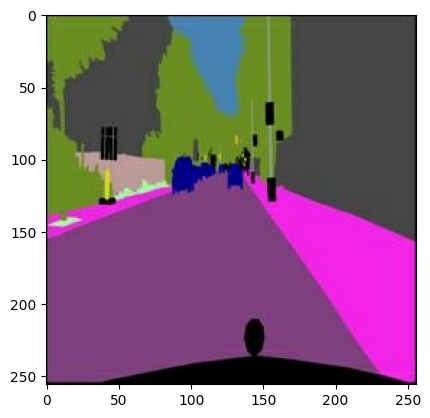

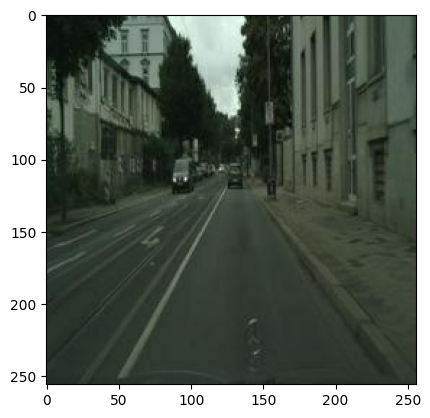

In [103]:
inp, re = load(str(dataset_name + 'image_100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [104]:
generator = Generator()

gen_output = generator(inp[tf.newaxis, ...], training=False)

discriminator = Discriminator()

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)

In [105]:
checkpoint_dir = './training_checkpoints_Ensemble'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

log_dir="logs_Ensemble/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Time taken for 1000 steps: 958.30 sec

---------------------------------------------------------------------
----------------------------Training---------------------------------
---------------------------------------------------------------------
Histogram Correlation: 0.5732421879377176 and standard deviation of: 0.19454766704654258
Template Matching Result: 0.5610963191717747 and standard deviation of: 0.21368874732917872
Feature Matching Ratio: 0.030514875030084054 and standard deviation of: 0.01951071528993677
Similarity: 0.4373805272118105 and standard deviation of: 0.07333460693336633
---------------------------------------------------------------------
--------------------------Validation---------------------------------
---------------------------------------------------------------------
Histogram Correlation: 0.6069358015847945 and standard deviation of: 0.21207768361086962
Template Matching Result: 0.5443309571221471 and standard deviation of: 0.20438253452783936
Feature M

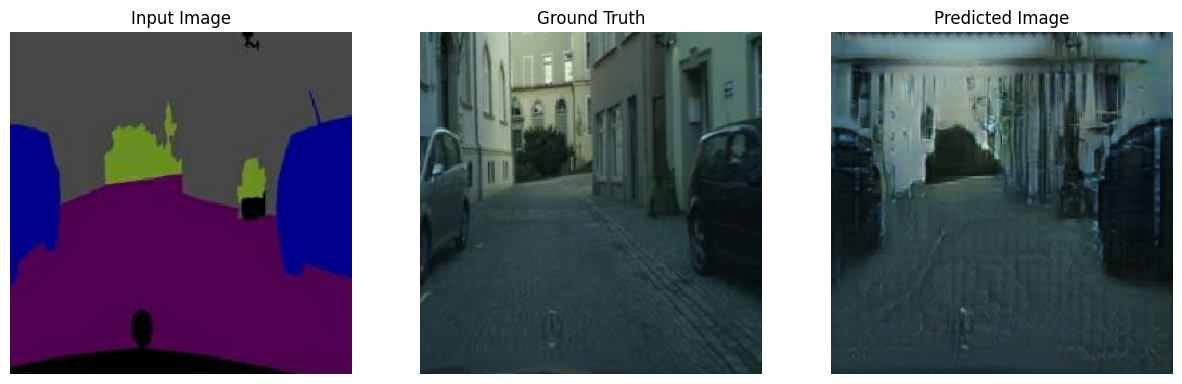

Step: 59k
....................................................................................................

In [106]:
metric, metrics_validation = fit(train_dataset, val_dataset, steps=60000)

np.save('Metrics_Ensemble', metric)
np.save('Metrics_Ensemble_Validation', metrics_validation)

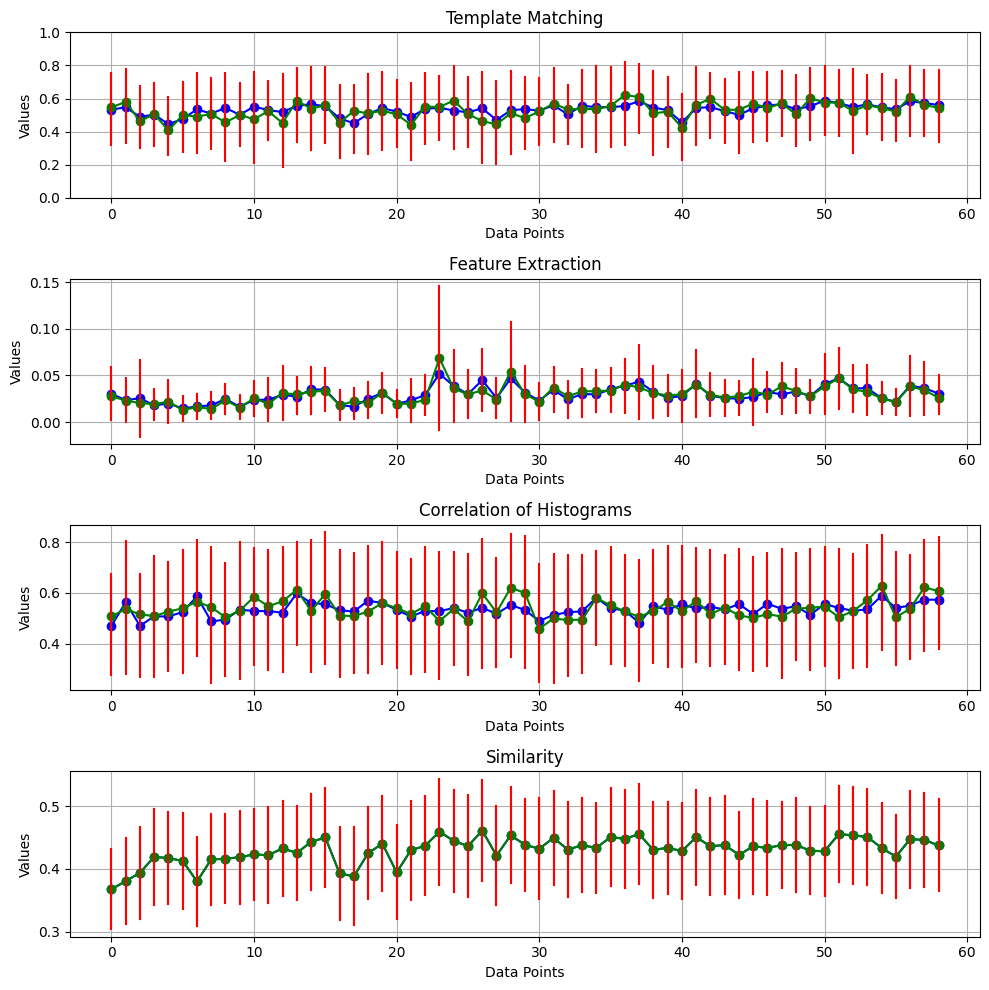

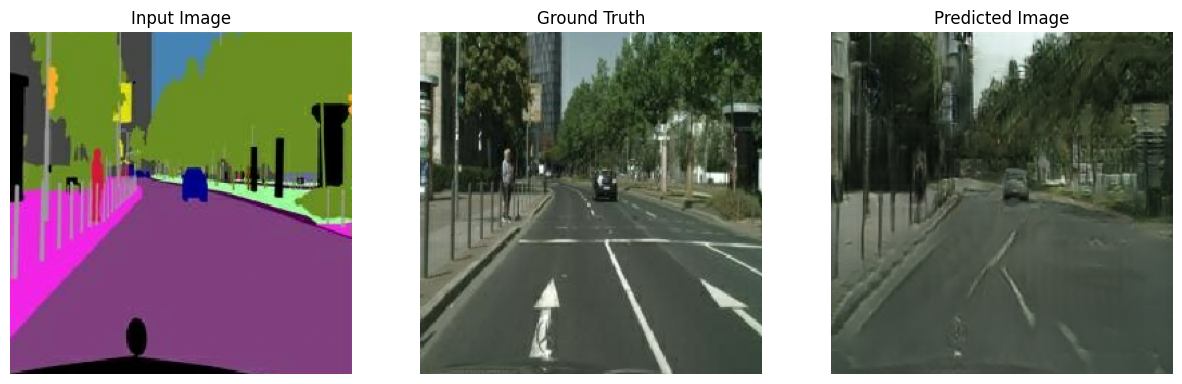

In [107]:
show_plots(metric, metrics_validation)

for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

### Comentar los resultados

In [108]:
predicted = []
targets = []

for inp, tar in test_dataset.take(50):
    out = generator(inp)
    targets.append(tar)
    predicted.append(out)

output = metrics(targets, predicted)

Histogram Correlation: 0.5608403917917287 and standard deviation of: 0.18117736974297302
Template Matching Result: 0.5633019250631333 and standard deviation of: 0.18841312620542272
Feature Matching Ratio: 0.027079285622340035 and standard deviation of: 0.01462398442687686
Similarity: 0.4357426141987477 and standard deviation of: 0.07827827343813071


## 4. Conclusions

Finally, let's look at some graphs where we show all the metrics of the model throughout the training with the three different architectures. 

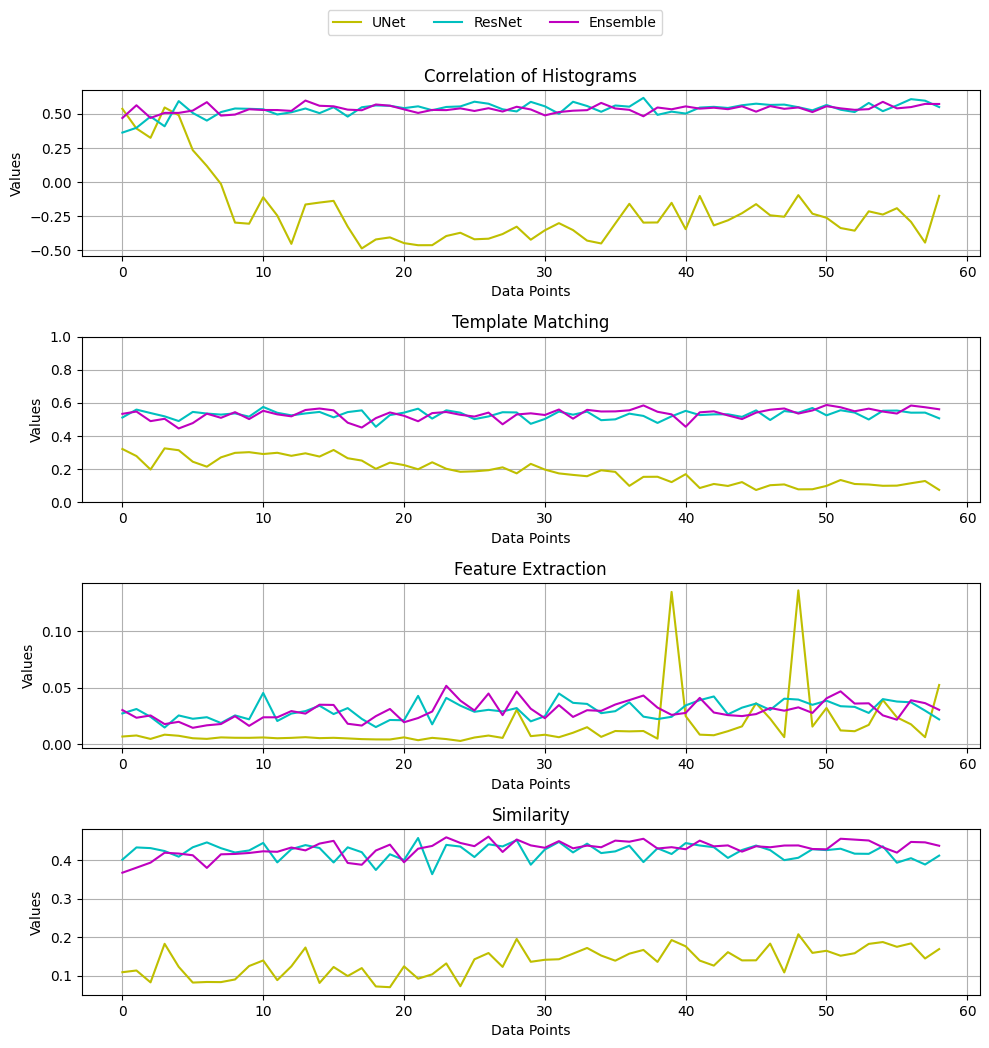

In [3]:
metric_ensemble = np.load('Metrics_Ensemble.npy')

corr_mean_ensemble = []
corr_std_ensemble = []
temp_mean_ensemble = []
temp_std_ensemble = []
feat_mean_ensemble = []
feat_std_ensemble = []
sim_mean_ensemble = []
sim_std_ensemble = []

for i in range(len(metric_ensemble)):
    corr_mean_ensemble.append(metric_ensemble[i][0])
    corr_std_ensemble.append(metric_ensemble[i][1])
    temp_mean_ensemble.append(metric_ensemble[i][2])
    temp_std_ensemble.append(metric_ensemble[i][3])
    feat_mean_ensemble.append(metric_ensemble[i][4])
    feat_std_ensemble.append(metric_ensemble[i][5])
    sim_mean_ensemble.append(metric_ensemble[i][6])
    sim_std_ensemble.append(metric_ensemble[i][7])



metric_resnet = metric = np.load('Metrics_ResNet.npy')

corr_mean_resnet = []
corr_std_resnet = []
temp_mean_resnet = []
temp_std_resnet = []
feat_mean_resnet = []
feat_std_resnet = []
sim_mean_resnet = []
sim_std_resnet = []

for i in range(len(metric_resnet)):
    corr_mean_resnet.append(metric_resnet[i][0])
    corr_std_resnet.append(metric_resnet[i][1])
    temp_mean_resnet.append(metric_resnet[i][2])
    temp_std_resnet.append(metric_resnet[i][3])
    feat_mean_resnet.append(metric_resnet[i][4])
    feat_std_resnet.append(metric_resnet[i][5])
    sim_mean_resnet.append(metric_resnet[i][6])
    sim_std_resnet.append(metric_resnet[i][7])



metric_unet = metric = np.load('Metrics_UNet.npy')

corr_mean_unet = []
corr_std_unet = []
temp_mean_unet = []
temp_std_unet = []
feat_mean_unet = []
feat_std_unet = []
sim_mean_unet = []
sim_std_unet = []

for i in range(len(metric_unet)):
    corr_mean_unet.append(metric_unet[i][0])
    corr_std_unet.append(metric_unet[i][1])
    temp_mean_unet.append(metric_unet[i][2])
    temp_std_unet.append(metric_unet[i][3])
    feat_mean_unet.append(metric_unet[i][4])
    feat_std_unet.append(metric_unet[i][5])
    sim_mean_unet.append(metric_unet[i][6])
    sim_std_unet.append(metric_unet[i][7])


# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Plot for Correlation of Histograms
axs[0].plot(corr_mean_unet, linestyle='-', color='y', label='UNet')

axs[0].plot(corr_mean_resnet, linestyle='-', color='c', label='ResNet')

axs[0].plot(corr_mean_ensemble, linestyle='-', color='m', label='Ensemble')

axs[0].set_title('Correlation of Histograms')
axs[0].set_xlabel('Data Points')
axs[0].set_ylabel('Values')
axs[0].grid(True)

# Plot for Template Matching
axs[1].plot(temp_mean_unet, linestyle='-', color='y', label='UNet')

axs[1].plot(temp_mean_resnet, linestyle='-', color='c', label='ResNet')

axs[1].plot(temp_mean_ensemble, linestyle='-', color='m', label='Ensemble')

axs[1].set_title('Template Matching')
axs[1].set_xlabel('Data Points')
axs[1].set_ylabel('Values') 
axs[1].set_ylim(0, 1)
axs[1].grid(True)

# Plot for Feature Extraction
axs[2].plot(feat_mean_unet, linestyle='-', color='y', label='UNet')

axs[2].plot(feat_mean_resnet, linestyle='-', color='c', label='ResNet')

axs[2].plot(feat_mean_ensemble, linestyle='-', color='m', label='Ensemble')

axs[2].set_title('Feature Extraction')
axs[2].set_xlabel('Data Points')
axs[2].set_ylabel('Values')
axs[2].grid(True)

# Plot for Similarity
axs[3].plot(sim_mean_unet, linestyle='-', color='y', label='UNet')

axs[3].plot(sim_mean_resnet, linestyle='-', color='c', label='ResNet')

axs[3].plot(sim_mean_ensemble, linestyle='-', color='m', label='Ensemble')

axs[3].set_title('Similarity')
axs[3].set_xlabel('Data Points')
axs[3].set_ylabel('Values')
axs[3].grid(True)

# Create a single legend outside the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()